# About

- 시계열로 밀어붙이기에는 label 에 비해 상대적으로 너무 데이터가 적어서 학습하기가 힘들것 같다.
- 불균형 데이터의 Classification 으로 무언가 조치가 필요해 보인다.
- Upsampling 보다는 다양한 모델을 앙상블하는게 좋을듯
- 아... 무언가 획기적인 방법이 필요하다. 

1. 한 개의 행은 0.02초 (second)를 의미합니다. 즉 하나의 id 에 대해서 600개의 time 이 존재하므로  총 12초(0.02*600)동안의 동작을 측정한 것입니다.

2. 이 때에 가속계와, 자이로스코프는 오른쪽 forearm(전완) 에 착용하여 측정한 데이터입니다.

3. 가속도계는 해당 방향으로의 가속도(g)를, 자이로스코프는 해당 방향으로의 dps(degrees per second)를 측정한 것입니다.


- 우선 가속도 방향은 항상 중력방향으로 작용한다. 그러므로 운동을 하지 않을 때에도 어느정도는 계속 측정이 되고있는 상태이다.
- 그렇다면 가속도의 합을 
- 가속도를 이용해서 각 각도 등을 측정 가능할 것이다. 

- x 축 방향(-)은 손바닥 방향으로 추정된다.
- 플랭크 시에 0 이였던 점 , push up 떄에 -1 인점 을 보아 맞는듯 하다.
- 그리고 acc 의 범위는 9.8 N = 1 으로 추정된다.(Push up 때에 -1 -> 즉 지구 중력은 9.8)
- 같은 운동에 대해 x 축은 비슷한 분포를 보이는 반면 y,x 축은 약간 역전된 느낌이다.
- 이는 즉 측정 기구를 찰때 전완근에 차기 때문에 y,z 의 측정은 불안정해 보인다.
- 그러므로! x 만 하는게 좋아보인다.?

- Moving average 를 통해서 그 추이를 알아내는게 매우 큰 도움이 된다.
- min max 의 차이를 얻어내는게 큰 도움이 된다.

- 갑자기 올라가는 지점인 첨도가 높은 지점의 정보를 추가해야될듯

- 이동평균과, 원래 값을 빼서, noise 를 측정하자!

# Setting

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization,GRU, LSTM
import warnings
from scipy.signal import find_peaks

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [2]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [3]:
#test'id'는 782개 
test['id'].nunique()

782

In [4]:
train_labels['label_desc'].unique()

array(['Shoulder Press (dumbbell)', 'Non-Exercise', 'Biceps Curl (band)',
       'Side Plank Right side', 'Plank', 'Chest Press (rack)',
       'Wall Squat', 'Russian Twist', 'Running (treadmill)',
       'Pushup (knee or foot variation)', 'Wall Ball',
       'Dynamic Stretch (at your own pace)',
       'Sit-up (hands positioned behind head)', 'Tap Right Device',
       'Static Stretch (at your own pace)', 'Device on Table',
       'Triceps extension (lying down)', 'Elliptical machine', 'Burpee',
       'Walking lunge', 'Lateral Raise', 'Jump Rope',
       'Triceps Kickback (knee on bench) (label spans both arms)',
       'Medicine Ball Slam',
       'Lunge (alternating both legs, weight optional)',
       'Fast Alternating Punches', 'Static stretch',
       'Squat Rack Shoulder Press', 'Overhead Triceps Extension',
       'Seated Back Fly', 'Bicep Curl', 'Side Plank Left side',
       'Dumbbell Squat (hands at side)', 'Dumbbell Deadlift Row',
       'Two-arm Dumbbell Curl (both arms, 

In [5]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [6]:
#782개의 id 별 동작 데이터를 활용해 각각의id가 어떤 동작인지를 분류하는 문제!!
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **데이터 살펴보기**

In [7]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
# 아 이거 너~ 무 불균형인데?
# Validation 이... 지금 그냥 다 0.5
train_labels['label_desc'].value_counts()

Non-Exercise                                                1518
Device on Table                                               97
Plank                                                         55
Wall Squat                                                    48
Jump Rope                                                     47
Tap Right Device                                              37
Two-arm Dumbbell Curl (both arms, not alternating)            37
Dip                                                           37
V-up                                                          36
Burpee                                                        35
Squat (arms in front of body, parallel to ground)             35
Pushup (knee or foot variation)                               35
Shoulder Press (dumbbell)                                     35
Lunge (alternating both legs, weight optional)                35
Overhead Triceps Extension                                    34
Sit-up (hands positioned 

In [8]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

- 데이터가 1422 개 이므로, 무조건 15개 내외로 변수를 짜야한다.
- 괜히 너무 col이 많아도 과적합됨.
- 어짜피 tree 모델인데.. 

- 어짜피 너무 불균형한 운동은 없다. 한쪽이 크면 음수쪽도 큼. 그러므로 max 면 충분할것
- 중요한건 acc 이다. 이게 중력의 영향때문에

- noise
    - 차이값이 중요 (이는 30 이동평균한 값을 이용해, 이와의 차이값을 이용하면 될듯)
    - 차이를 알게된다면 심하게 진동하는 값에 대한 measure 로 작용 가능
- diff
    - 최대와 최소의 차이가 중요
    - 어느정도 심하게 변하고 있는지에 대한 measure  가능
- change_x
    - 평균과 차이의 절댓값 합
    - 평균으로부터 얼마나 떨어지는가의 예시가됨.
- local maxima(30) 
    - 30 이동평균시에 로컬 maximum
    - acc, gy 2개의 값이 생긴다.
- mean
    - 각 값의 min 은 매우 중요하다
    - 모든 운동은 '대칭적' 으로 이루어진다는 점에서 그 mean 을 통해서 손목 기계의 위치가 달라질것
    - 다만 gy 의 mean 은 거의다 0이다. 즉 추가함의 의미가 없어보인다.
    
- quantile(0.8) 보다 큰 값에 대해, 이어지는 행렬의 갯수가 50개 이 


In [9]:
def plot(exercise,df,lis1,lis2) : # 각 운동(exersice) 에 대해서 df set 에 대해 lis1, lis2 에 해당하는 그래프를 그려준다.
    plt.figure(figsize= (25,20))
    plt.subplots_adjust(top = 3)
    for i in range(0,5) :
        plt.subplot(12,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels['label_desc'] == exercise ]['id']))
        plt.plot(df[df['id']==idx].loc[:,lis1])
        plt.legend(lis1)
        plt.title(exercise)
        plt.subplot(12,2,2*i+2)
        plt.plot(df[df['id']==idx].loc[:,lis2])
        plt.legend(lis2)
        plt.title(exercise)

In [10]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,train,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

# EDA

## Noise

- 우선 각 이동평균을 정의해야한다.

In [10]:
def moving(train):
    df_train = train
    df_train['index']= df_train.index
    df_train1 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(3,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_train2 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(31,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_new = pd.merge(df_train, df_train2, on='index')
    df_new.drop(columns=['id_y','time','index'],inplace = True)
    def quant(x):
        val1 = np.quantile(x,0.9)
        val2 = np.quantile(x,0.1)
        return(val1-val2)
    df_noise= df_new[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values - df_new[['acc_x_y', 'acc_y_y', 'acc_z_y', 'gy_x_y', 'gy_y_y', 'gy_z_y']].values
    normalize = df_new.groupby('id_x').agg(quant)[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values
    df_noise = pd.DataFrame(df_noise,columns=['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y', 'noise_gy_z'])
    df_noise = pd.concat([df_new['id_x'],df_noise],axis=1)
    df_noise = np.abs(df_noise)
    df_noise = df_noise.groupby('id_x').agg(sum)
    df_noise = df_noise/ normalize
    df = df_noise
    df.reset_index(inplace = True,drop= True)
    return df

In [142]:
df_train = train

In [10]:
df_train['index']= df_train.index

In [11]:
df_train1 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(3,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()

In [12]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,df_train,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

In [13]:
df_train2 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(31,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()

In [14]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,df_train2,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

In [15]:
df_new = pd.merge(df_train, df_train2, on='index')

In [16]:
df_new.drop(columns=['id_y','time','index'],inplace = True)

In [17]:
def quant(x):
    val1 = np.quantile(x,0.9)
    val2 = np.quantile(x,0.1)
    return(val1-val2)

In [70]:
df_new.groupby('id_x').agg(quant)

,acc_x_x,acc_y_x,acc_z_x,gy_x_x,gy_y_x,gy_z_x,acc_x_y,acc_y_y,acc_z_y,gy_x_y,gy_y_y,gy_z_y
id_x,,,,,,,,,,,,
0,0.485813,0.459452,0.359679,35.009676,55.847462,66.886289,0.368117,0.365954,0.248686,16.440489,41.376343,49.799877
1,1.280924,0.808870,1.344033,190.785635,219.591462,151.586553,1.030312,0.701696,1.260075,122.826032,156.518104,109.057984
2,1.826512,0.296013,0.650163,55.868831,294.064426,31.341472,1.682653,0.123207,0.417491,15.861085,267.238814,13.833168
3,0.318138,0.498164,0.491315,102.120821,82.714983,61.610444,0.213480,0.407664,0.442888,73.398713,43.193443,31.912727
4,1.077010,1.130512,0.611722,98.181020,65.698641,55.049113,1.080506,1.043894,0.441988,85.790101,51.299675,41.403776
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,1.014310,0.450695,0.866975,68.911849,66.626004,57.905585,0.921266,0.443130,0.817635,58.816540,48.561444,50.334803
3121,0.454768,0.298366,0.223799,86.198225,40.857757,31.379543,0.276747,0.254817,0.153288,68.577011,33.640495,18.440602
3122,1.798096,0.806575,0.554048,375.146808,609.670038,327.849583,0.872801,0.534219,0.300124,278.242739,495.775330,262.981544


In [18]:
df_noise= df_new[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values - df_new[['acc_x_y', 'acc_y_y', 'acc_z_y', 'gy_x_y', 'gy_y_y', 'gy_z_y']].values
normalize = df_new.groupby('id_x').agg(quant)[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values
df_noise = pd.DataFrame(df_noise,columns=['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y', 'noise_gy_z'])
df_noise = pd.concat([df_new['id_x'],df_noise],axis=1)
df_noise = np.abs(df_noise)
df_noise = df_noise.groupby('id_x').agg(sum)
df_noise = df_noise/ normalize
df = df_noise
df.reset_index(inplace = True,drop= True)

In [40]:
#df_new[['gy_x_x','gy_y_x','gy_z_x','gy_x_y','gy_y_y','gy_z_y']] = df_new[['gy_x_x','gy_y_x','gy_z_x','gy_x_y','gy_y_y','gy_z_y']]/360

In [41]:
#train = df_new 

In [102]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607


- 아래를 보면 역시 Noise 의 경우에 각 운동마다 다른 값을 가짐을 알 수 있다.
- 별로 움직임이 없는 Device on table,plank 등은 매우 작은값을 가진다
- 큰 움직임이 많은 값은 큰 값을 가짐을 알 수 있다.

In [43]:
df_ex = pd.DataFrame()
for exer in train_labels['label_desc'].unique() :
    val = np.mean(df.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
    df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)

In [44]:
df_ex.T

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z
Shoulder Press (dumbbell),102.698383,105.320726,113.152820,113.203678,114.093672,115.965404
Non-Exercise,79.075843,80.160695,66.097853,117.871778,102.504712,104.705375
Biceps Curl (band),51.831901,126.491289,89.439125,145.575730,61.513656,77.273032
Side Plank Right side,170.362037,159.624964,161.883393,193.755968,187.843807,186.460875
Plank,154.379102,141.066078,144.568324,207.213366,207.669163,206.296734
Chest Press (rack),107.433514,127.630727,114.115128,148.385539,99.326302,95.217756
Wall Squat,140.127598,131.291789,114.793242,192.846164,183.026630,177.731188
Russian Twist,81.357449,117.771614,78.696908,119.292968,49.155504,75.242819
Running (treadmill),153.035165,166.840062,147.809053,160.804150,140.997248,154.596394
Pushup (knee or foot variation),165.103845,152.294671,133.152515,157.005796,114.022060,137.217524


## Local maximum

- train_2 (center 을 True 로 한 이동평균) 데 애해서, local maximum 의 수를 센다.
- 노이즈가 매우 많은 경우 큰 값을 나타나게 된다.

In [45]:
from scipy.signal import find_peaks
def pick(x) :
    val = len(find_peaks(x)[0])
    return val

In [46]:
ex = df_train2.groupby('id').agg(pick)
df_ex = pd.DataFrame()
for exer in train_labels['label_desc'].unique() :
    val = np.mean(ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
    df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)

- 아래 표를 보았을 때, 각, 운동별 편차가 나타나고있다. 주로 많이 움직이지 않는 운동의 경우 큰 값을 나타내고 있다.
- 많이 움직이지 않는다는것은 그만큼 작은 움직임으로 방향이 바뀌며 움직인다는것이기 때문에 그에 따라 gy,acc 의 local maxmum 이 많이 나타나고있다.

In [47]:
df_ex.T

,index,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
Shoulder Press (dumbbell),0.0,21.685714,43.228571,40.657143,32.542857,17.800000,18.314286
Non-Exercise,0.0,32.966403,36.270751,28.131752,29.777997,20.640975,18.251647
Biceps Curl (band),0.0,13.782609,50.173913,20.695652,43.434783,8.521739,11.913043
Side Plank Right side,0.0,121.700000,98.150000,114.050000,82.050000,90.450000,89.250000
Plank,0.0,125.090909,101.636364,109.709091,72.018182,103.036364,91.872727
Chest Press (rack),0.0,52.458333,60.958333,57.958333,48.833333,25.958333,24.916667
Wall Squat,0.0,57.291667,58.687500,49.166667,45.708333,39.125000,33.187500
Russian Twist,0.0,19.400000,37.966667,22.733333,29.666667,7.733333,11.833333
Running (treadmill),0.0,51.818182,40.727273,31.909091,37.772727,21.727273,23.954545
Pushup (knee or foot variation),0.0,87.971429,56.485714,54.942857,53.657143,20.742857,27.200000


- side plank 의 예시를 한번 살펴보았다. 
- 그 편차가 크지 않고 다 큰 값을 나타내고 있음을 알 수 있다.
- 즉 이 값을 회귀에 이용할 수 있을것이다.

In [48]:
ex.iloc[train_labels[train_labels['label_desc'] == 'Side Plank Right side']['id'],:].T

id,12,61,333,339,356,544,660,780,1002,1204,1260,1639,1678,1761,1773,1861,1906,2188,2657,2915
index,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acc_x,135.0,123.0,139.0,120.0,92.0,118.0,82.0,114.0,97.0,149.0,130.0,87.0,130.0,129.0,158.0,118.0,107.0,127.0,146.0,133.0
acc_y,99.0,108.0,121.0,90.0,115.0,94.0,67.0,110.0,82.0,124.0,83.0,67.0,106.0,109.0,121.0,89.0,70.0,102.0,92.0,114.0
acc_z,122.0,100.0,155.0,118.0,116.0,126.0,98.0,123.0,96.0,133.0,118.0,74.0,142.0,133.0,128.0,109.0,64.0,112.0,90.0,124.0
gy_x,83.0,68.0,99.0,89.0,103.0,65.0,69.0,108.0,69.0,104.0,60.0,61.0,90.0,68.0,126.0,78.0,52.0,75.0,87.0,87.0
gy_y,86.0,116.0,101.0,100.0,63.0,82.0,62.0,93.0,66.0,136.0,68.0,58.0,102.0,104.0,116.0,90.0,87.0,99.0,77.0,103.0
gy_z,88.0,87.0,118.0,88.0,107.0,90.0,65.0,101.0,66.0,98.0,81.0,51.0,102.0,91.0,122.0,97.0,59.0,102.0,81.0,91.0


In [49]:
df_local = ex.iloc[:,1:].reset_index(drop=True)

In [50]:
df_local.column = ['local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x', 'local_gy_y', 'local_gy_z']

In [51]:
df = pd.concat([df,df_local],axis=1)

In [52]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0


## Diff

- 3 이동평균을 제안한 값에 대하여, 최대값과 최소값의 차이를 조사한다.
- 그럴 경우 큰 차이가 난다면, 가동범위가 매우 크다는것을 의미한다.

In [53]:
df_diff = df_train1.groupby('id').max().iloc[:,1:] - df_train1.groupby('id').min().iloc[:,1:]

In [54]:
df_diff = df_diff.reset_index().iloc[:,1:]

In [55]:
df_diff

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937
1,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801
2,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089
3,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133
4,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932
...,...,...,...,...,...,...
3120,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522
3121,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650
3122,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547
3123,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151


In [56]:
df_ex = pd.DataFrame()
for exer in train_labels['label_desc'].unique() :
    val = np.mean(df_diff.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
    df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)

In [57]:
df_ex.T

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
Shoulder Press (dumbbell),1.008618,0.686170,0.734093,148.885562,156.828020,136.129255
Non-Exercise,1.931279,1.568553,1.374356,377.203153,340.452579,309.373577
Biceps Curl (band),2.058504,0.911434,1.120887,178.917422,466.639596,290.560586
Side Plank Right side,0.287734,0.431638,0.211111,66.357652,52.945011,28.106972
Plank,0.178697,0.348318,0.176896,76.144390,26.841796,24.865055
Chest Press (rack),0.793688,0.837244,0.744328,163.494727,150.750173,125.034311
Wall Squat,0.717331,0.629077,0.511191,171.231837,120.204251,118.399401
Russian Twist,2.528983,1.716729,1.898611,304.462801,576.627374,406.481369
Running (treadmill),2.258199,2.084582,1.429186,294.901757,342.904169,277.541524
Pushup (knee or foot variation),0.564567,0.984615,1.283977,207.753662,199.194202,120.000431


- 버터플라이 Sit-up 의 경우 그 차이에 대해서 비슷한값들을 가지고 있습니다. 
- 다만 가동 범위에 약간 차이가 있는데, 이 때에 mean 을 취해야 할 듯 하다.

In [58]:
df_diff.iloc[train_labels[train_labels['label_desc'] == 'Butterfly Sit-up']['id'],:]

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
138,1.942971,1.776905,2.954438,306.953542,611.833113,214.742902
226,3.323504,4.875785,4.412730,1715.266289,848.558867,859.933726
332,2.795885,4.607340,2.242404,577.650737,416.786624,758.927724
344,2.817026,4.739370,2.087957,495.862553,187.386315,713.945173
370,1.497776,2.572835,1.106377,245.219983,191.629812,365.229954
492,1.703896,3.250939,0.991999,458.262610,438.363628,594.622056
565,2.726557,5.100054,1.666550,429.957694,370.933484,736.481907
1249,2.724417,4.552880,1.350914,509.788424,619.592287,713.522254
1271,1.816528,4.480172,1.815448,340.371741,386.364369,752.503011
1426,1.900400,3.546651,1.491069,476.744811,223.976304,686.562722


In [59]:
df_diff.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [60]:
df_diff.columns = ['dif_acc_x', 'dif_acc_y', 'dif_acc_z', 'dif_gy_x', 'dif_gy_y', 'dif_gy_z']

In [61]:
df = pd.concat([df,df_diff],axis=1)

In [62]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151


## Mean

- mean 은 3 평균을 취한 train1 에서부터 진행하자

In [63]:
df_mean = df_train1.groupby('id').mean().reset_index().iloc[:,2:5]

In [64]:
df_mean.columns

Index(['acc_x', 'acc_y', 'acc_z'], dtype='object')

In [65]:
df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z']

In [66]:
df = pd.concat([df,df_mean],axis=1)

In [67]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676


## Dif_Mean

- Dif_Mean 은 평균을 취한 값과 그 차이를 계산한다

In [68]:
train = train.iloc[:,:-1]

In [69]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [70]:
df_temp = train.groupby('id').transform(np.mean).iloc[:,1:]

In [71]:
df_temp

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
1,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
2,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
3,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
4,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
...,...,...,...,...,...,...
1874995,-0.434048,-0.623010,0.226848,-1.638705,-1.226870,-3.246825
1874996,-0.434048,-0.623010,0.226848,-1.638705,-1.226870,-3.246825
1874997,-0.434048,-0.623010,0.226848,-1.638705,-1.226870,-3.246825
1874998,-0.434048,-0.623010,0.226848,-1.638705,-1.226870,-3.246825


In [72]:
df_mean = train[['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']] - df_temp

In [73]:
df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_gy_x', 'mean_gy_y', 'mean_gy_z']

In [74]:
df_mean

,mean_acc_x,mean_acc_y,mean_acc_z,mean_gy_x,mean_gy_y,mean_gy_z
0,0.274758,0.039100,0.221975,1.273661,-27.189503,-32.858219
1,0.356368,0.019497,0.187978,2.168370,-35.779597,-26.109323
2,0.373280,0.023357,0.117039,-1.752008,-40.763058,-26.201736
3,0.361766,-0.011895,0.155212,4.578255,-50.238337,-28.636120
4,0.369558,0.030714,0.147898,6.151976,-54.547054,-29.143342
...,...,...,...,...,...,...
1874995,-0.278482,-0.035348,0.066860,-27.729152,-102.786795,-73.043612
1874996,-0.248988,-0.035456,0.102375,-28.510384,-100.569940,-73.378262
1874997,-0.230682,-0.043616,0.137266,-26.234390,-97.549203,-76.118300
1874998,-0.196485,-0.059555,0.146848,-21.997845,-97.912625,-77.012653


In [75]:
df_temp = pd.concat([train[['id']],df_mean],axis=1)

In [76]:
df_temp = np.abs(df_temp)

In [77]:
df_mean = df_temp.groupby('id').sum()

In [78]:
df_mean = df_mean.reset_index(drop=True)

In [79]:
df_mean.columns

Index(['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_gy_x', 'mean_gy_y',
       'mean_gy_z'],
      dtype='object')

In [80]:
df_mean.columns =['dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z', 'dif_mean_gy_x', 'dif_mean_gy_y','dif_mean_gy_z']

In [81]:
df = pd.concat([df,df_mean],axis=1)

In [82]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.720455,0.702188,0.600540,67.579723,147.113306,132.248937,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,2.990440,1.798357,1.851409,547.856254,676.248815,597.788801,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.312151,0.645145,1.161400,176.370625,530.180757,94.426089,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.736728,0.807585,0.803121,248.540605,229.549479,138.416133,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,2.447628,3.389703,3.391560,1306.548640,510.894933,387.262932,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,1.809807,1.297442,1.258163,266.115491,291.966093,181.535522,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.098763,0.673599,0.535038,250.918383,83.237862,94.770650,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,2.651044,2.047613,1.085082,781.982663,764.798410,568.583547,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.801997,1.167649,0.996628,353.894778,458.672910,502.196151,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607


In [83]:
df_ex = pd.DataFrame()
for exer in train_labels['label_desc'].unique() :
    val = np.mean(df.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
    df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)

In [84]:
df_ex

,Shoulder Press (dumbbell),Non-Exercise,Biceps Curl (band),Side Plank Right side,Plank,Chest Press (rack),Wall Squat,Russian Twist,Running (treadmill),Pushup (knee or foot variation),Wall Ball,Dynamic Stretch (at your own pace),Sit-up (hands positioned behind head),Tap Right Device,Static Stretch (at your own pace),Device on Table,Triceps extension (lying down),Elliptical machine,Burpee,Walking lunge,Lateral Raise,Jump Rope,Triceps Kickback (knee on bench) (label spans both arms),Medicine Ball Slam,"Lunge (alternating both legs, weight optional)",Fast Alternating Punches,Static stretch,Squat Rack Shoulder Press,Overhead Triceps Extension,Seated Back Fly,Bicep Curl,Side Plank Left side,Dumbbell Squat (hands at side),Dumbbell Deadlift Row,"Two-arm Dumbbell Curl (both arms, not alternating)",Walk,Arm Band Adjustment,Band Pull-Down Row,Squat Jump,"Squat (arms in front of body, parallel to ground)",Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Butterfly Sit-up,V-up,Lawnmower (right arm),Squat (hands behind head),Squat,Jumping Jacks,Repetitive Stretching,Squat (kettlebell / goblet),Power Boat pose,Pushups,Dumbbell Row (knee on bench) (label spans both arms),Crunch,Sit-ups,Dumbbell Row (knee on bench) (left arm),Dip,Kettlebell Swing,Dumbbell Row (knee on bench) (right arm),Lawnmower (left arm),Rowing machine
noise_acc_x,102.698383,79.075843,51.831901,170.362037,154.379102,107.433514,140.127598,81.357449,153.035165,165.103845,179.504655,123.669805,56.490145,62.934656,108.426352,169.251277,32.780705,105.684495,134.104368,117.239375,40.744540,183.240936,117.080252,108.251668,106.460668,176.559359,70.963799,121.093743,48.744194,55.171650,36.138691,140.187330,93.513203,95.474264,31.605651,145.821435,77.747111,121.341207,136.397982,96.779420,185.854206,73.428098,64.991041,76.224387,49.292324,78.283599,89.118946,140.507112,105.958936,76.761471,121.471465,165.761130,120.349251,72.720181,82.171877,174.523268,164.728040,52.929491,79.414052,136.139474,72.485080
noise_acc_y,105.320726,80.160695,126.491289,159.624964,141.066078,127.630727,131.291789,117.771614,166.840062,152.294671,140.368160,125.431788,63.916101,86.505304,82.050845,169.246182,55.316575,179.031313,164.946062,126.546700,90.976411,186.680997,108.555871,127.803265,119.263843,192.535026,79.195159,70.679543,59.225918,90.677284,98.553771,120.312295,135.099767,121.697206,86.962196,123.242582,90.267535,141.424747,132.146097,81.351637,142.943077,68.802246,53.422648,52.525018,83.297832,68.777925,77.060873,138.969353,90.003872,88.268366,161.264140,161.077713,139.159969,84.053974,93.988398,150.819209,135.010092,81.771999,135.639047,96.470478,156.214451
noise_acc_z,113.152820,66.097853,89.439125,161.883393,144.568324,114.115128,114.793242,78.696908,147.809053,133.152515,122.004436,105.115400,83.108364,64.432721,75.565885,159.745057,63.739644,165.342750,160.486296,123.600439,74.222779,180.759348,102.235923,134.152422,113.056679,189.209009,61.804060,79.263833,45.546533,70.081014,73.861184,121.775377,101.132305,102.690569,72.628430,133.946267,56.052516,111.825688,147.749517,87.227510,139.821891,73.630897,68.232071,82.349201,96.669503,80.423183,94.129654,167.205220,89.362587,76.308774,114.258280,143.361532,128.014548,64.038860,81.955549,152.435897,126.042118,75.658930,124.606135,91.212265,129.153943
noise_gy_x,113.203678,117.871778,145.575730,193.755968,207.213366,148.385539,192.846164,119.292968,160.804150,157.005796,120.295090,123.396629,78.493000,135.849863,144.671944,815.189257,114.871617,155.970957,165.660237,148.801757,100.208128,181.119955,151.362072,150.561632,141.551724,166.105669,143.351539,104.820831,126.250374,120.578053,129.231138,168.603427,111.482514,136.280821,121.185496,131.725010,136.450770,129.305824,149.256199,131.623244,173.940286,119.472950,95.552900,108.215464,110.518983,59.343667,135.295965,164.771166,143.100804,112.269662,179.511306,158.078767,138.085953,59.590340,122.293709,151.161670,161.163227,81.084547,135.768321,60.870812,14

In [85]:
df_ex[['Plank','Device on Table']]

,Plank,Device on Table
noise_acc_x,154.379102,169.251277
noise_acc_y,141.066078,169.246182
noise_acc_z,144.568324,159.745057
noise_gy_x,207.213366,815.189257
noise_gy_y,207.669163,701.090854
noise_gy_z,206.296734,836.658190
acc_x,125.090909,105.154639
acc_y,101.636364,106.958763
acc_z,109.709091,102.536082
gy_x,72.018182,124.845361


# 모델링 준비

## y 준비

In [86]:
y = train_labels['label']

## 데이터 변환

In [87]:
#df_new = pd.DataFrame()
#df_new['noise_acc'] = np.mean(df.iloc[:,0:3],axis=1)
#df_new['noise_gy'] = np.mean(df.iloc[:,3:6],axis=1)
#df_new['local_acc'] = np.mean(df.iloc[:,6:9],axis=1)
#df_new['local_gy'] = np.mean(df.iloc[:,9:12],axis=1)
#df_new['dif_acc'] = np.mean(df.iloc[:,12:15],axis=1)
#df_new['dif_gy'] = np.mean(df.iloc[:,15:18],axis=1)

In [88]:
#dif_new = pd.concat([df_new,df.iloc[:,18:]],axis=1)

In [89]:
X = df.copy()

## Scaling

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [91]:
X = scaler.fit_transform(X)

In [92]:
X = pd.DataFrame(X,columns= df.columns)

## Split

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)


# **모델링**

## LGBM

In [94]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [135]:
#d_train 시에는 아래와 같이 d_train 의 형태로 바꾸어 주어야 한다.

model = LGBMClassifier(objective = 'multi_logloss',
                       metric = 'multi_logloss',
                       boosting ='dart',
                       drop_rate = 0.5,
                       n_estimators= 400,
                       learning_rate= 0.1,
                       min_data_in_leaf = 100,
                       bagging_fraction = 0.5,
                       feature_fraction = 0.5,
                      seed = 42)

In [136]:
model.fit(X_train,y_train,
         eval_set = (X_val,y_val), # evaluate 할 셋
         verbose = 50, # 언제마다 보여줄지
         early_stopping_rounds= 100 # 언제 학습이 끝나는 기준을 잡을지
         ) 

[50]	valid_0's multi_logloss: 1.49303
[100]	valid_0's multi_logloss: 1.25753
[150]	valid_0's multi_logloss: 1.10243
[200]	valid_0's multi_logloss: 0.908246
[250]	valid_0's multi_logloss: 0.884593
[300]	valid_0's multi_logloss: 0.871802
[350]	valid_0's multi_logloss: 0.885791
[400]	valid_0's multi_logloss: 0.897012


LGBMClassifier(bagging_fraction=0.5, boosting='dart', drop_rate=0.5,
               feature_fraction=0.5, metric='multi_logloss',
               min_data_in_leaf=100, n_estimators=400,
               objective='multi_logloss', seed=42)

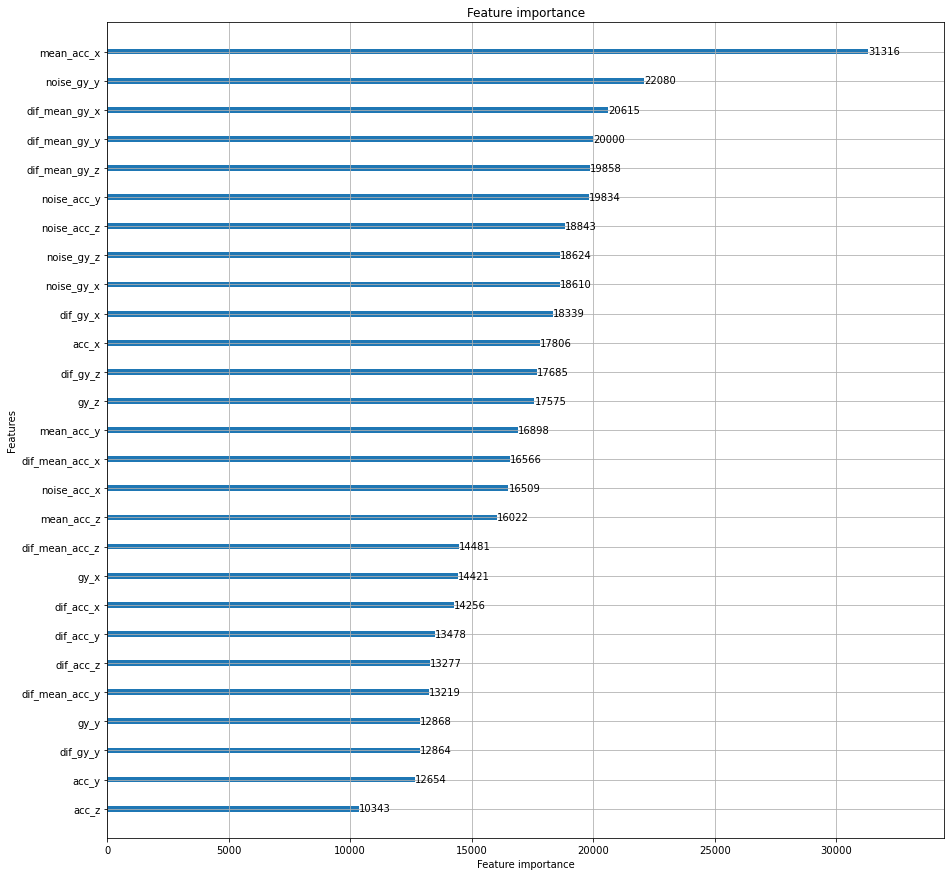

In [137]:
ax = lgb.plot_importance(model, max_num_features=80, figsize=(15,15))
plt.show()

In [138]:
from sklearn.metrics import confusion_matrix

In [139]:
q = pd.DataFrame(range(0,61),columns=['label'])

In [140]:
idx = np.array(pd.merge(q,train_labels[['label','label_desc']],on='label').drop_duplicates()['label_desc'])

In [141]:
from sklearn.metrics import classification_report

class_name = idx
print( classification_report(y_val,model.predict(X_val), target_names= class_name ) )

                                                          precision    recall  f1-score   support

                                     Arm Band Adjustment       0.00      0.00      0.00         4
                                      Band Pull-Down Row       1.00      0.50      0.67         2
                                              Bicep Curl       0.50      0.50      0.50         2
                                      Biceps Curl (band)       0.75      0.75      0.75         4
                                                  Burpee       0.88      0.78      0.82         9
                                        Butterfly Sit-up       1.00      0.22      0.36         9
                                      Chest Press (rack)       0.71      0.56      0.63         9
                                                  Crunch       0.75      1.00      0.86         3
                                         Device on Table       0.97      0.93      0.95        30
                   

In [94]:
confusion= pd.DataFrame(confusion_matrix(y_val, model.predict(X_val)),columns = idx)

In [102]:
confusion.index = idx

In [103]:
confusion

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
Arm Band Adjustment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Band Pull-Down Row,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bicep Curl,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Biceps Curl (band),0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Burpee,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Butterfly Sit-up,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chest Press (rack),0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
Crunch,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Device on Table,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dip,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
y_val

2537    44
541     26
501     26
3051    26
1136    50
        ..
113     57
794     26
1063    26
488     26
1230    14
Name: label, Length: 625, dtype: int64

In [109]:
model.predict(X_val)

array([44, 60, 26, 26, 26, 35, 26, 28, 26, 38, 26, 26, 26, 55, 26, 27, 23,
       26, 28, 46,  6,  6, 36, 26, 26, 26,  2, 26, 60, 28, 29,  8, 49, 26,
       26, 26, 23, 26, 26, 18, 26, 18, 26, 26, 25, 40, 26, 26, 26, 18, 11,
        8,  7,  5, 20, 26,  5, 26, 28, 26, 26, 26, 26, 17,  9, 26, 26, 26,
       26, 26, 26, 37, 26, 26, 41, 26, 37, 26, 26, 26, 28, 31, 26, 26, 60,
       26, 17, 39, 35, 18, 42, 47, 59, 26, 26, 46, 26,  8, 26, 30,  4,  8,
        5, 26, 26, 59, 26,  8, 24, 26,  6,  8, 26,  4, 18, 26, 28, 26, 26,
        7, 29, 33, 14, 26, 41, 26, 26, 18, 26, 54, 33, 24, 26, 26, 22, 26,
       26, 26, 26, 26, 15, 26,  8, 26, 20, 39, 26, 47,  8, 26, 26, 26,  8,
       35,  2, 26,  8, 26, 26, 15, 26, 26, 24, 26, 26, 26, 26,  4, 26, 26,
       26, 50, 12, 26, 30, 42, 56, 36, 26, 24, 42, 26, 27, 26, 26,  8, 26,
       28,  3, 26, 25,  9, 26, 26,  1,  9, 26, 26, 26, 26, 31, 26, 60, 17,
       26, 26, 59, 44, 55, 24, 24, 60, 26, 26, 11, 26, 26, 26, 26, 26, 26,
       26, 37, 26, 17, 26

# 제출

In [132]:
prediction=model.predict(test_X)

NameError: name 'test_X' is not defined

In [ ]:
prediction.shape

(782, 61)

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission.loc[:,['26']] = 1

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission.to_csv('./Submission/submission_all_None.csv', index=False)